In [1]:
# install torch and pandas before running
import sys, os, cv2, glob, json, gc
import pandas as pd
import multiprocessing
from functools import partial

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import itertools
from itertools import chain
from tqdm import tqdm
import circstat as CS
import scipy as sc
import math

from processing import *
from kinematics import *
from skeleton import *

OVERWRITE = True
USE_CENTER_INSTANCE = False
USE_BEST_INSTANCE = True
dataset = 'CHOP_face'

json_path = f'./data/Infant Pose Data/{dataset}/annotations'
json_files = os.listdir(json_path)
directory = f'./data'

save_path = f'./pose_estimates/{dataset}_norm'

if not os.path.exists(save_path):
    os.makedirs(save_path)

kp_mapping = {
    **{i: "Chin" for i in range(0, 33)},
    **{i: "Right_brow" for i in range(33, 42)},
    **{i: "Left_brow" for i in range(42, 51)},
    **{i: "Nose" for i in range(51, 66)},
    **{i: "Right_Eye" for i in range(66, 75)},
    **{i: "Left_Eye" for i in range(75, 84)},
    **{i: "Mouth" for i in range(84, 104)},
    104: "Right_Pupil",
    105: "Left_Pupil"
}

# Define the DataFrame columns as specified
columns = ['video_number', 'video', 'bp', 'frame', 'x', 'y', 'c','fps', 'pixel_x', 'pixel_y', 'time', 'part_idx']
data = []  # This will hold the data to be loaded into the DataFrame

vid_info = pd.read_csv(f'./data/{dataset}_video_info.csv')

In [2]:
import os
import json
import pandas as pd
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

# Constants
USE_CENTER_INSTANCE = True
USE_BEST_INSTANCE = False
OVERWRITE = False
columns = ["file_number", "fname", "bp", "frame_id", "x", "y", "c", "fps", "pixel_x", "pixel_y", "time", "part_idx"]

def process_file(args):
    """Function to process a single file."""
    file_number, file, json_path, save_path, vid_info, kp_mapping = args
    
    # Construct the full file path
    file_path = os.path.join(json_path, file)
    fname = file.split('.')[0]
    interim = []

    if not OVERWRITE and os.path.exists(f'{save_path}/{fname}.csv'):
        return  # Skip if already exists and not overwriting

    try:
        # Open and load the JSON data
        with open(file_path, 'r') as f:
            frames = json.load(f)
            info = vid_info[vid_info['video'] == fname]
            fps = info['fps'].values[0]

            pixel_x = info['width'].values[0]
            pixel_y = info['height'].values[0]
            
            center_x = pixel_x / 2
            center_y = pixel_y / 2
            
            # Iterate through each frame in the JSON file
            for frame in frames:
                frame_id = frame['frame_id']
                if 'instances' in frame and len(frame['instances']) > 0:

                    if USE_CENTER_INSTANCE:
                        instance_id = get_center_instance(frame['instances'], center_x, center_y)
                    elif USE_BEST_INSTANCE:
                        instance_id = get_best_instance(frame['instances'])
                    else:
                        instance_id = 0

                    keypoints = frame['instances'][instance_id]['keypoints']
                    confidence = frame['instances'][instance_id]['keypoint_scores']

                    # Iterate through each keypoint
                    for part_idx, (x, y) in enumerate(keypoints):
                        bp = kp_mapping[part_idx]
                        time = frame_id / fps
                        c = confidence[part_idx]

                        row = [file_number, fname, bp, frame_id, x, y, c, fps, pixel_x, pixel_y, time, part_idx]
                        interim.append(row)

        interim_df = pd.DataFrame(interim, columns=columns)
        interim_df.to_csv(f'{save_path}/{fname}.csv', index=False)
        return
    
    except Exception as e:
        return
    
def process_annotations_multiprocess(json_files, json_path, save_path, vid_info, kp_mapping):
    """Run the annotation processing using multiprocessing."""
    args = [
        (file_number, file, json_path, save_path, vid_info, kp_mapping)
        for file_number, file in enumerate(json_files)
    ]

    # Set up a pool of workers
    with Pool(processes=20) as pool:
        pool.map(process_file, args)


In [ ]:
process_annotations_multiprocess(json_files, json_path, save_path, vid_info, kp_mapping)

In [3]:
import numpy as np

def get_chin_and_eyebrow_points(df):
    """
    Extract the center of the chin and the midpoint of the eyebrows.

    Parameters:
    - df (pd.DataFrame): DataFrame containing keypoints with 'part_idx', 'x', 'y'.

    Returns:
    - chin_center (tuple): The average (x, y) coordinates of the chin.
    - eyebrow_midpoint (tuple): The midpoint between the left and right eyebrows.
    """
    # Filter keypoints for chin, right eyebrow, and left eyebrow
    chin_points = df[df['part_idx'].isin(range(0, 33))][['x', 'y']].values
    right_brow_points = df[df['part_idx'].isin(range(33, 42))][['x', 'y']].values
    left_brow_points = df[df['part_idx'].isin(range(42, 51))][['x', 'y']].values

    # Calculate the center of the chin (average of all chin points)
    #chin_center = df[df['part_idx'] == 16][['x', 'y']].values

    chin_center = chin_points.mean(axis=0) if len(chin_points) > 0 else (0, 0)

    # Calculate the midpoint between the centers of the right and left eyebrows
    right_brow_center = right_brow_points.mean(axis=0) if len(right_brow_points) > 0 else (0, 0)
    left_brow_center = left_brow_points.mean(axis=0) if len(left_brow_points) > 0 else (0, 0)
    eyebrow_midpoint = (right_brow_center + left_brow_center) / 2

    return chin_center, eyebrow_midpoint

def get_rotation_angle(chin_center, eyebrow_midpoint):
    """
    Calculates the angle to rotate the face so the chin is directly below the eyebrow midpoint.

    Parameters:
    - chin_center (tuple): The (x, y) coordinates of the chin center.
    - eyebrow_midpoint (tuple): The (x, y) coordinates of the eyebrow midpoint.

    Returns:
    - angle (float): Rotation angle in degrees (clockwise).
    """
    x1, y1 = chin_center
    x2, y2 = eyebrow_midpoint

    # Calculate the angle between the vertical axis and the line connecting chin and eyebrow midpoint
    delta_x = x2 - x1
    delta_y = y2 - y1
    theta = np.arctan2(delta_y, delta_x)  # Angle in radians

    # Adjust angle to align the chin directly below eyebrows (relative to vertical axis)
    angle = np.degrees(theta) + 180  # Add 180 degrees for alignment with vertical

    return -angle  # Negative for clockwise rotation

def calculate_face_rotation(df):
    """
    Calculates the rotation angle for a given DataFrame of keypoints.

    Parameters:
    - df (pd.DataFrame): Input DataFrame with 'part_idx', 'x', and 'y'.

    Returns:
    - rotation_angle (float): The angle to rotate the face (clockwise).
    """
    chin_center, eyebrow_midpoint = get_chin_and_eyebrow_points(df)
    rotation_angle = get_rotation_angle(chin_center, eyebrow_midpoint)

    return rotation_angle


In [4]:
def get_rotation_matrix(angle):
    """Create a 2D rotation matrix."""
    return np.array([[np.cos(angle), -np.sin(angle)],
                        [np.sin(angle), np.cos(angle)]])

def normalize_points(points):
    """Normalize points to the range [-1, 1]."""
    min_vals = points.min(axis=0)
    max_vals = points.max(axis=0)
    scale = max(max_vals - min_vals)
    return 2 * ((points - min_vals) / scale) - 1

def rotate_and_normalize(df):
    """
    Reads a CSV file, rotates and normalizes x, y coordinates, and writes to a new CSV file.

    Parameters:
    - input_csv (str): Path to the input CSV file.
    - output_csv (str): Path to save the rotated and normalized CSV file.
    """


    # Load data

    # Ensure columns exist
    required_columns = ['video_number', 'video', 'bp', 'frame', 'x', 'y', 'c', 'fps', 'pixel_x', 'pixel_y', 'time', 'part_idx']

    if not all(col in df.columns for col in required_columns):
        raise ValueError("Input CSV is missing required columns.")

    result = []
    
    # Process each frame independently
    for (video, frame), group in df.groupby(['video', 'frame']):
        # Extract x, y coordinates
        coords = group[['x', 'y']].values
        
        # Center the coordinates to the mean
        center = coords.mean(axis=0)
        centered_coords = coords - center
        
        # Rotate the coordinates by a fixed angle (e.g., align along x-axis)
        angle = calculate_face_rotation(group)
        rotation_matrix = get_rotation_matrix(angle)  # No rotation applied, adjust angle if needed
        rotated_coords = np.dot(centered_coords, rotation_matrix.T)
        
        # Normalize the rotated coordinates to [-1, 1]
        normalized_coords = normalize_points(rotated_coords)
        
        # Update the group with new x, y values
        transformed_group = group.copy()
        transformed_group['x'] = normalized_coords[:, 0]
        transformed_group['y'] = normalized_coords[:, 1]
        
        result.append(transformed_group)
        del transformed_group, group
    # Concatenate results return rotated and normalized DataFrame
    return pd.concat(result).reset_index(drop=True)

In [5]:
# Smooth and interpolate the data

def process_dataframe(file):
    
    df = pd.read_csv(os.path.join(pose_estimate_path, file))
    df.rename(columns={'file_number': 'video_number', 'fname': 'video', 'frame_id': 'frame'}, inplace=True)

    if df.empty:
        #print("DataFrame is empty, skipping processing.")
        return
    print(f"Processing DataFrame for video_number: {df['video_number'].iloc[0]}")
    
    try:
        session = df['video'].unique()[0].split('_')[1]
        infant = df['video'].unique()[0].split('_')[0]
        age = df['video'].unique()[0].split('_')[2]
        
        print(f'infant: {infant} {session} {age}')
        
    except:
        f'could not process video {df["video"].unique()[0]}'
        return

    median_window = 1
    mean_window = 1
    delta_window = 0.25  # Smoothing applied to delta_x, velocity, acceleration

    df['x'] = pd.to_numeric(df['x'])
    df['y'] = pd.to_numeric(df['y'])

    # Interpolate
    df = df.groupby(['video', 'bp']).apply(interpolate_df).reset_index(drop=True)

    # Median and mean filter
    median_window = 0.5
    mean_window = 0.5
    df = df.groupby(['video', 'bp']).apply(lambda x: smooth(x, 'y', median_window, mean_window)).reset_index(drop=True)
    df = df.groupby(['video', 'bp']).apply(lambda x: smooth(x, 'x', median_window, mean_window)).reset_index(drop=True)
    # Rotate and normalize the data
    df = rotate_and_normalize(df).reset_index(drop=True)

    df.to_csv(f'{pose_estimate_path}/smooth/{infant}_{session}_{age}_smooth_pose_estimates_coords.csv')


In [6]:
# Smooth detections and compute features
pose_estimate_path = f'./pose_estimates/{dataset}_norm'
csv_path = f'{pose_estimate_path}/pose_estimates_{dataset}.csv'
save_path = f'{pose_estimate_path}/pose_estimates_{dataset}_processed.csv'

# List of subdirectories to create
subdirs = [
    "",
    "xdf",
    "adf",
    "xy_features",
    "angle_features",
    "xy_features/total",
    "angle_features/total",
    "xy_features/windows",
    "angle_features/windows",
    "smooth"
]

# Create necessary directories
for subdir in subdirs:
    os.makedirs(f'{pose_estimate_path}/{subdir}', exist_ok=True)


In [7]:
faces_files = os.listdir(f'{pose_estimate_path}')
faces_files = [file for file in faces_files if file.endswith('.csv')]
               
with Pool(processes=10) as pool:
    pool.map(process_dataframe, faces_files)

Processing DataFrame for video_number: 0
Processing DataFrame for video_number: 1568
infant: 81 1 1
Processing DataFrame for video_number: 354
infant: 65238 1 0
infant: 1364 2 1
Processing DataFrame for video_number: 1547
Processing DataFrame for video_number: 849
infant: 1393 1 1Processing DataFrame for video_number: 928

Processing DataFrame for video_number: 1792
infant: 7 1 1
infant: 13567 1 0
infant: 256 1 1
Processing DataFrame for video_number: 998
Processing DataFrame for video_number: 201
infant: 56459 1 0
infant: 507 1 1
Processing DataFrame for video_number: 2240
infant: 41514 1 0
Processing DataFrame for video_number: 4
infant: 211 1 1
Processing DataFrame for video_number: 207
infant: 75706 2 0
Processing DataFrame for video_number: 226
infant: 260 5 1
Processing DataFrame for video_number: 807
infant: 287 1 1
Processing DataFrame for video_number: 1
infant: 129 1 0
Processing DataFrame for video_number: 1736
infant: 25023 3 0
Processing DataFrame for video_number: 1763
in

In [ ]:
from matplotlib.animation import FuncAnimation

def init_animation(scatter, text):
    """Initialization function for the animation."""
    scatter.set_offsets([])
    text.set_text('')
    return scatter, text

def update_animation(frame, df, scatter, text):
    """Update function for the animation."""
    # Filter data for the current frame
    current_frame_data = df[df['frame_id'] == frame]
    
    # Ensure we get a 2D array for coordinates
    if not current_frame_data.empty:        
        coordinates = current_frame_data[['x', 'y']].values
    else:
        coordinates = np.empty((0, 2))  # Empty 2D array with shape (0, 2)
    
    print(f"Frame: {frame}, Coordinates shape: {coordinates.shape}, Data: {coordinates}")


    # Update scatter plot and frame number text
    scatter.set_offsets(coordinates)
    text.set_text(f"Frame: {frame}")
    return scatter, text

def animate_coordinates(file_path, output_gif=None):
    """
    Animates the time series of (x, y) coordinates from a normalized, rotated file.

    Parameters:
    - file_path (str): Path to the normalized and rotated CSV file.
    - output_gif (str, optional): Path to save the animation as a GIF file. If None, displays the animation.
    """
    # Load the normalized and rotated file
    df = pd.read_csv(file_path)
    
    # Ensure required columns exist
    required_columns = ['frame', 'x', 'y', 'bp']
    if not all(col in df.columns for col in required_columns):
        raise ValueError("Input CSV is missing required columns: 'frame', 'x', 'y', 'bp'")

    # Sort the data by frame_id
    df = df.sort_values(by='frame')
    
    # Extract unique frame IDs and body parts
    frame_ids = df['frame'].unique()

    # Initialize the figure
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(-1.2, 1.2)  # Normalized range [-1, 1] with padding
    ax.set_ylim(-1.2, 1.2)
    ax.set_title("Time Series of Keypoints")
    ax.set_xlabel("Normalized X")
    ax.set_ylabel("Normalized Y")

    # Initialize scatter plot and text
    scatter = ax.scatter([], [], s=50, color='blue')  # Placeholder for keypoints
    text = ax.text(-1, 1, '', fontsize=12)

    # Create the animation
    ani = FuncAnimation(
        fig, 
        update_animation, 
        frames=frame_ids, 
        init_func=lambda: init_animation(scatter, text), 
        fargs=(df, scatter, text), 
        blit=True, 
        repeat=True
    )
    
    # Save as GIF or display
    if output_gif:
        ani.save(output_gif, writer='pillow', fps=10)
        print(f"Animation saved to {output_gif}")
    else:
        plt.show()


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

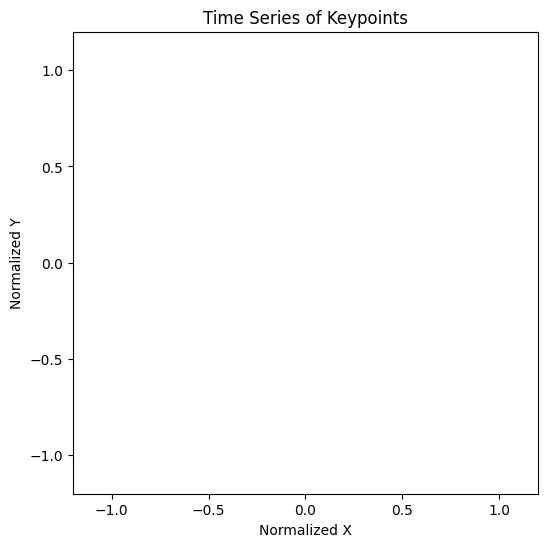

In [9]:
# Input file path (normalized and rotated file)
input_file = '/workspaces/gma_score_prediction_from_video/pose_estimates/CHOP_face_norm/smooth/4_2_1_smooth_pose_estimates_coords.csv'
anim_folder = '/workspaces/gma_score_prediction_from_video/pose_estimates/CHOP_face_norm/anim'

os.makedirs(anim_folder, exist_ok=True)

# To display the animation:
# animate_coordinates(input_file)

# To save the animation as a GIF:
animate_coordinates(input_file, output_gif="keypoints_animation.gif")